In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
import torch
import matplotlib.pyplot as plt
from models import create_model 

import yaml
from pipeline.walkforward import WFCVGenerator
from pipeline.wf_config import WFConfig
from utils.paths import CONFIG_DIR





# -------- load config --------
cfg = yaml.safe_load(open(CONFIG_DIR / "debug.yaml"))

# import wfcv
wf_config = WFConfig(**cfg["walkforward"])

wf = WFCVGenerator(config=wf_config)

test_data = {}
data = {}
for i, fold_data in enumerate(wf.folds()):

    X_test = fold_data[4]
    y_test = fold_data[5]

    test_data[i] = [X_test, y_test]
    data[i] = fold_data

In [48]:
y_test

array([ 0.008179,  0.004859,  0.017413, ..., -0.031428,  0.006944,
        0.028733], shape=(115910,))

/tmp/ipykernel_73810/3690765928.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location="cuda")


[[ 0.051454  0.        0.070213 ... -0.013874 -0.0444    0.010899]
 [-0.006803  0.031202  0.00369  ... -0.018379  0.017934 -0.023256]
 [ 0.002923  0.025137  0.003554 ... -0.019115  0.007218 -0.009316]
 ...
 [ 0.040984 -0.015748  0.0112   ... -0.00292   0.001464 -0.004386]
 [ 0.004372 -0.000768  0.020759 ...  0.010714  0.01437   0.00836 ]
 [-0.00857  -0.003531  0.00562  ...  0.007882  0.015291  0.004254]]


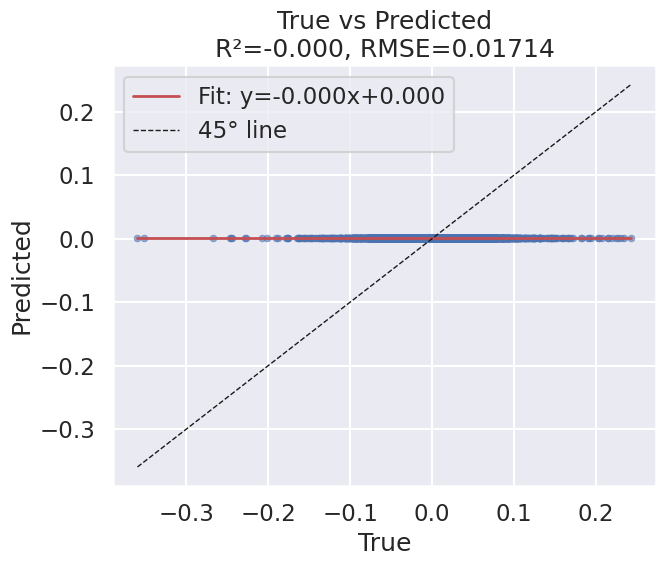

/tmp/ipykernel_73810/3690765928.py:82: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(y_pred, fill=True, alpha=0.5, label="Predicted", linewidth=2)


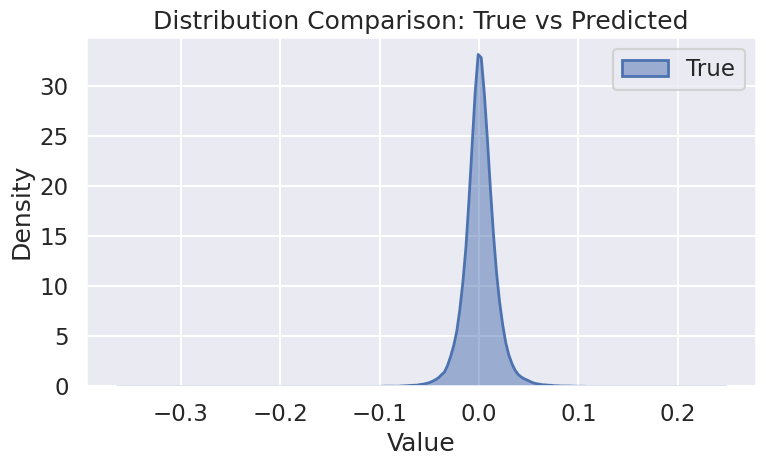

In [86]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import json

trial = "20251016_170201"
base = f"experiments/exp_006_pippo_6layers_no_dropoutl2/trial_{trial}/"
conifg_path = f"{base}config_snapshot.json"

with open(conifg_path, 'r') as f:
    cfg = json.load(f)

cfg = cfg["cfg"]

hparams = cfg["model"]["hparams"]
input_shape = (cfg["walkforward"]["lags"],)
fold = 0
ckpt_path = f"{base}/fold_{fold:03d}/model_best.pt"
checkpoint = torch.load(ckpt_path, map_location="cuda")

def fold_analysis(ckpt, data):


    X_test = data[0]
    print(X_test)
    y_test = data[1]


    # --- rebuild and load model ---
    # Remove _orig_mod. prefix from keys
    state_dict = {k.replace("_orig_mod.", ""): v for k, v in ckpt["model_state"].items()}

    # Load cleaned state dict
    model = create_model(cfg["model"], input_shape)
    model.load_state_dict(state_dict)
    model.to("cuda").eval()

    # --- make predictions ---
    X = torch.as_tensor(X_test, dtype=torch.float32, device="cuda")
    y_true = torch.as_tensor(y_test, dtype=torch.float32, device="cuda")

    with torch.no_grad():
        y_pred = model(X).squeeze(-1).cpu().numpy()

    y_true = y_true.cpu().numpy()


    # --- style ---
    sns.set_theme(style="darkgrid", context="talk")

    # --- regression fit ---
    reg = LinearRegression().fit(y_true.reshape(-1,1), y_pred)
    slope, intercept = reg.coef_[0], reg.intercept_
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    x_line = np.linspace(y_true.min(), y_true.max(), 200)
    y_line = reg.predict(x_line.reshape(-1,1))

    # ===================================================
    # 1️⃣ Scatter plot: True vs Predicted
    # ===================================================
    plt.figure(figsize=(7,6))
    sns.scatterplot(x=y_true, y=y_pred, s=25, alpha=0.6, edgecolor=None)
    plt.plot(x_line, y_line, 'r-', lw=2, label=f'Fit: y={slope:.3f}x+{intercept:.3f}')
    plt.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()], 'k--', lw=1, label="45° line")
    plt.title(f"True vs Predicted\nR²={r2:.3f}, RMSE={rmse:.4g}")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ===================================================
    # 2️⃣ Separate plot: Marginal KDEs
    # ===================================================
    plt.figure(figsize=(8,5))
    sns.kdeplot(y_true, fill=True, alpha=0.5, label="True", linewidth=2)
    sns.kdeplot(y_pred, fill=True, alpha=0.5, label="Predicted", linewidth=2)
    plt.title("Distribution Comparison: True vs Predicted")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, X, y_pred, y_true


model, X, y_pred, y_true = fold_analysis(checkpoint, test_data[fold])

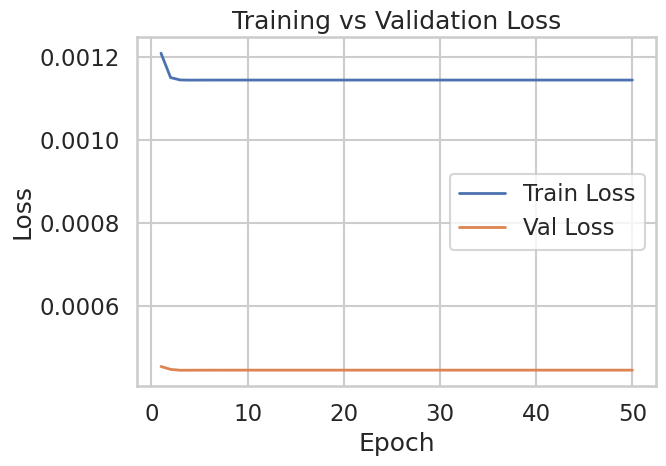

In [87]:
def plot_training_history(ckpt):
    """Plot train vs validation loss curves from the saved checkpoint."""
    history = ckpt.get("history", None)
    if not history:
        print("No training history found in checkpoint.")
        return

    # Convert list of dicts to separate arrays
    tr_losses = [h["tr_loss"] for h in history]
    val_losses = [h["val_loss"] for h in history]
    epochs = np.arange(1, len(tr_losses) + 1)

    sns.set_theme(style="whitegrid", context="talk")
    plt.figure(figsize=(7,5))
    plt.plot(epochs, tr_losses, label="Train Loss", lw=2)
    plt.plot(epochs, val_losses, label="Val Loss", lw=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_history(checkpoint)

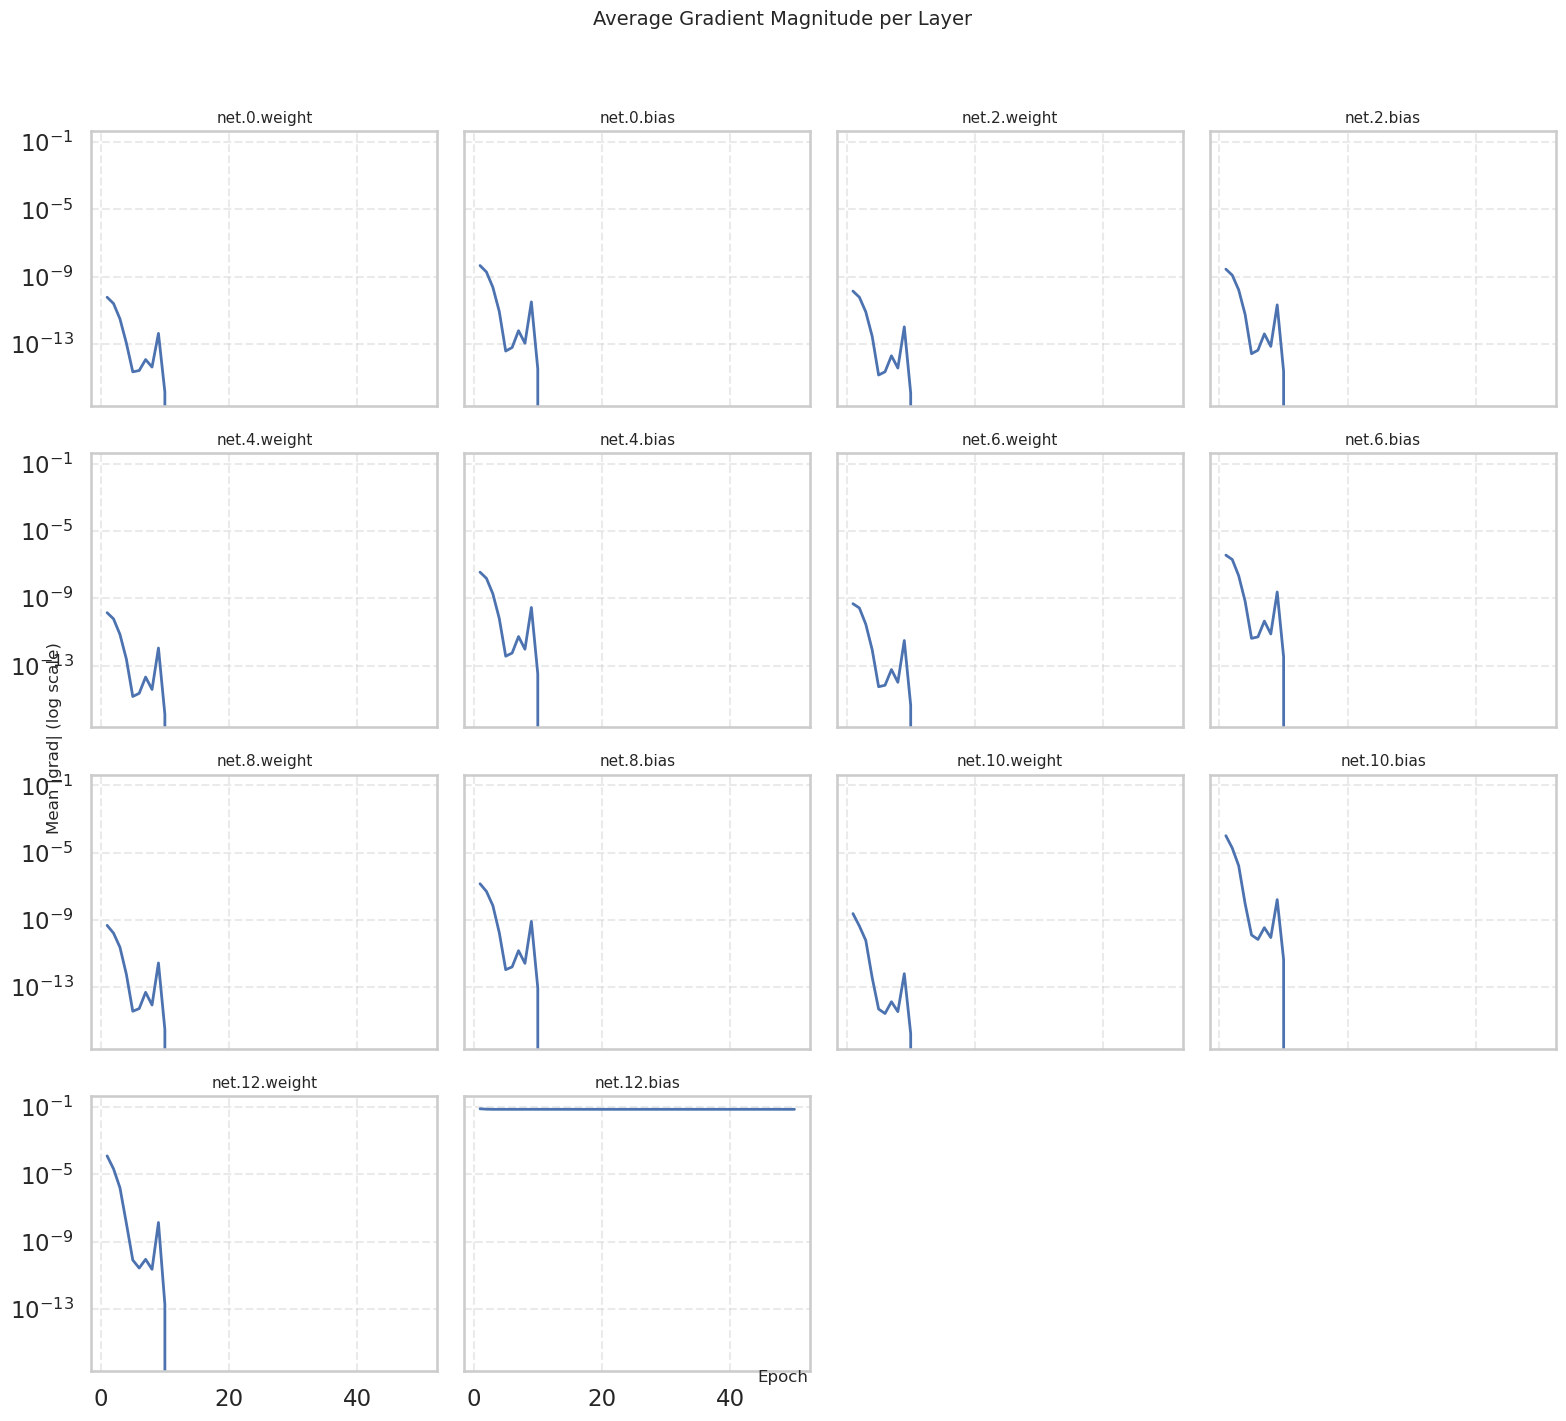

In [88]:
import matplotlib.pyplot as plt
import pandas as pd
import math

def plot_grad(ckpt):
    grad_history = ckpt.get("grad_history", [])
    if not grad_history:
        print("No grad_history found in checkpoint.")
        return

    df = pd.DataFrame(grad_history)
    if "epoch" not in df.columns:
        print("No 'epoch' column found in grad_history.")
        return

    df.set_index("epoch", inplace=True)
    
    # Clean column names for display (remove prefixes like _orig_mod.)
    df.columns = [c.replace("_orig_mod.", "") for c in df.columns]

    # --- grid setup ---
    n_cols = 4
    n_layers = len(df.columns)
    n_rows = math.ceil(n_layers / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3.5 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        ax = axes[i]
        ax.plot(df.index, df[col], lw=2)
        ax.set_title(col, fontsize=11)
        ax.set_yscale("log")
        ax.grid(True, linestyle="--", alpha=0.4)
    
    # Hide empty tiles if #layers < grid size
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Average Gradient Magnitude per Layer", fontsize=14, y=1.02)
    fig.text(0.5, 0.04, "Epoch", ha="center", fontsize=12)
    fig.text(0.04, 0.5, "Mean |grad| (log scale)", va="center", rotation="vertical", fontsize=12)
    plt.tight_layout()
    plt.show()


plot_grad(checkpoint)

In [ ]:
ckpt = checkpoint
grad_history = ckpt.get("grad_history", [])

df = pd.DataFrame(grad_history)

df.set_index("epoch", inplace=True)

# Clean column names for display (remove prefixes like _orig_mod.)
df.columns = [c.replace("_orig_mod.", "") for c in df.columns]
df


,net.0.weight,net.0.bias,net.2.weight,net.2.bias,net.4.weight,net.4.bias,net.6.weight,net.6.bias,net.8.weight,net.8.bias,net.10.weight,net.10.bias,net.12.weight,net.12.bias
epoch,,,,,,,,,,,,,,
1,5.947334e-11,4.573123e-09,1.374911e-10,2.793124e-09,1.391639e-10,3.589075e-08,4.763577e-10,3.699063e-07,4.778163e-10,1.428744e-07,2.392362e-09,1.027410e-04,1.255579e-04,0.079742
2,2.504935e-11,1.887140e-09,5.975467e-11,1.213225e-09,5.961409e-11,1.536264e-08,2.659487e-10,2.020890e-07,1.642857e-10,4.980436e-08,4.367737e-10,1.882589e-05,2.131182e-05,0.075429
3,3.076732e-12,2.313556e-10,8.011565e-12,1.626788e-10,7.133628e-12,1.842179e-09,2.871418e-11,2.184663e-08,2.382484e-11,7.158713e-09,6.089580e-11,1.665869e-06,1.602492e-06,0.074088
4,1.117936e-13,8.438738e-12,2.805593e-13,5.697131e-12,2.430544e-13,6.284025e-11,8.673764e-13,6.658354e-10,5.865329e-13,1.747319e-10,3.677148e-13,9.378328e-09,1.226422e-08,0.074126
5,2.168627e-15,3.738505e-14,1.402047e-15,2.596893e-14,1.440196e-15,3.604360e-13,5.479835e-15,4.137751e-12,3.705978e-15,1.105878e-12,5.007938e-15,1.273182e-10,7.996714e-11,0.074191
6,2.596005e-15,6.072161e-14,2.186638e-15,4.209013e-14,2.221914e-15,5.511966e-13,6.726540e-15,5.073624e-12,5.335717e-15,1.605382e-12,2.721510e-15,6.933920e-11,2.681233e-11,0.074216
7,1.168242e-14,6.074385e-13,1.956744e-14,3.935591e-13,2.067814e-14,5.296956e-12,5.760861e-14,4.403124e-11,4.964341e-14,1.482237e-11,1.363613e-14,3.469800e-10,8.839382e-11,0.074226
8,4.169445e-15,1.093353e-13,3.655286e-15,7.083549e-14,3.773637e-15,9.359087e-13,1.007801e-14,7.587840e-12,8.723586e-15,2.624012e-12,3.518101e-15,8.974643e-11,2.242673e-11,0.074229
9,4.200427e-13,3.144015e-11,1.029211e-12,2.089492e-11,1.101208e-12,2.846903e-10,3.080036e-12,2.366178e-09,2.764773e-12,8.232839e-10,6.357561e-13,1.619651e-08,1.368720e-08,0.074236


In [95]:
x_tr = data[0][0]
y_tr = data[0][1]
print(np.mean(x_tr))
print(np.mean(y_tr))

0.00011338940795775483
0.00015514361230578382


In [93]:
np.unique(y_pred)

array([0.00032209], dtype=float32)

In [53]:
print(f"y_true range: [{y_true.min():.4f}, {y_true.max():.4f}], std: {y_true.std():.4f}")
print(f"y_pred range: [{y_pred.min():.4f}, {y_pred.max():.4f}], std: {y_pred.std():.4f}")

y_true range: [-0.5314, 0.3124], std: 0.0183
y_pred range: [0.0024, 0.0024], std: 0.0000


In [65]:
# Print some model weights to verify they're not all zeros/same
for name, param in model.named_parameters():
    print(f"{name}: mean={param.mean():.6f}, std={param.std():.6f}")
    #break  # just check first layer

net.0.weight: mean=0.001709, std=0.128584
net.0.bias: mean=0.000511, std=0.124722
net.2.weight: mean=-0.002231, std=0.018185
net.2.bias: mean=-0.003197, std=0.017739
net.4.weight: mean=-0.001198, std=0.018328
net.4.bias: mean=-0.004865, std=0.017665
net.6.weight: mean=-0.001262, std=0.018516
net.6.bias: mean=-0.003981, std=0.016612
net.8.weight: mean=-0.001564, std=0.018357
net.8.bias: mean=-0.003494, std=0.015401
net.10.weight: mean=-0.000737, std=0.018302
net.10.bias: mean=-0.009172, std=0.009931
net.12.weight: mean=-0.000340, std=0.013024
net.12.bias: mean=0.002385, std=nan


/tmp/ipykernel_73810/2507637824.py:3: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /opt/conda/conda-bld/pytorch_1729647406761/work/aten/src/ATen/native/ReduceOps.cpp:1823.)
  print(f"{name}: mean={param.mean():.6f}, std={param.std():.6f}")


In [55]:
print(f"X shape: {X.shape}")
print(f"X range: [{X.min():.6f}, {X.max():.6f}]")
print(f"X std: {X.std():.6f}")
print(f"Any NaN in X? {torch.isnan(X).any()}")

X shape: torch.Size([115910, 20])
X range: [-0.531402, 0.312442]
X std: 0.018268
Any NaN in X? False


In [56]:
print(f"Model training mode: {model.training}")  # Should be False

Model training mode: False
